In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Dataset

In [9]:
df=pd.read_csv('household_power_consumption.txt', delimiter=';')
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (2075259, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


# Feature extraction (~5m)

In [10]:
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df.dropna(subset=['Global_active_power'])
df['date_time']=pd.to_datetime(df['date_time']) 
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)
df=df.loc[:,['date_time','Global_active_power', 'year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)

print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.date_time.min())
print('The time series ends on: ', df.date_time.max())

df.head()

Number of rows and columns after removing missing values: (2049280, 7)
The time series starts from:  2006-12-16 17:24:00
The time series ends on:  2010-12-11 23:59:00


,date_time,Global_active_power,year,quarter,month,day,weekday
0,2006-12-16 17:24:00,4.2160,2006,4,12,16,0
1,2006-12-16 17:25:00,5.3600,2006,4,12,16,0
2,2006-12-16 17:26:00,5.3740,2006,4,12,16,0
3,2006-12-16 17:27:00,5.3880,2006,4,12,16,0
4,2006-12-16 17:28:00,3.6660,2006,4,12,16,0


# Statistical Normality

In [12]:
stat, p = stats.normaltest(df.Global_active_power)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=724881.795, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: 4.218671866132129
Skewness of normal distribution: 1.7862320846320843


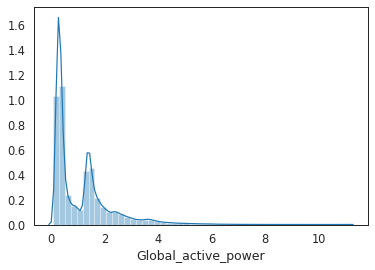

In [13]:
sns.distplot(df.Global_active_power);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Global_active_power)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Global_active_power)))

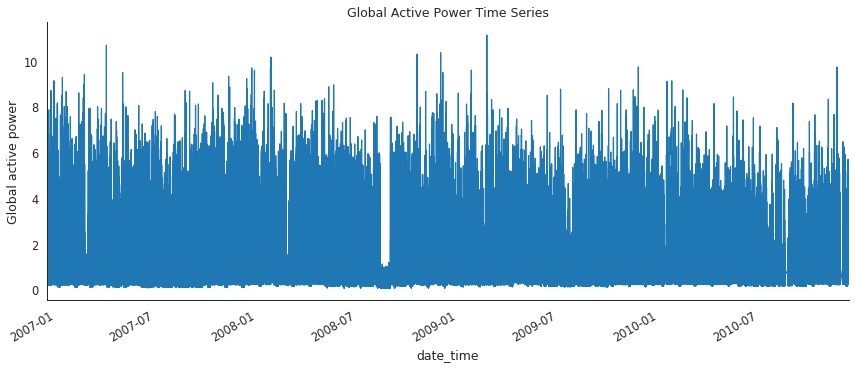

In [14]:
df1=df.loc[:,['date_time','Global_active_power']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Global active power')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Global Active Power Time Series')
sns.despine(top=True)
plt.show();

# Test & train dataset

In [19]:
dataset = df.Global_active_power.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Model

In [22]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

W0930 09:50:02.736163 140359850293056 deprecation.py:506] From /home/akondas/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0930 09:50:03.042293 140359850293056 deprecation.py:323] From /home/akondas/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1639393 samples, validate on 409825 samples
Epoch 1/20
1639393/1639393 [==============================] - 140s 86us/sample - loss: 7.6519e-04 - val_loss: 4.2963e-04
Epoch 2/20
1639393/1639393 [==============================] - 148s 90us/sample - loss: 6.6471e-04 - val_loss: 4.5142e-04
Epoch 3/20
1639393/1639393 [==============================] - 126s 77us/sample - loss: 6.5329e-04 - val_loss: 4.5449e-04
Epoch 4/20
1639393/1639393 [==============================] - 84s 51us/sample - loss: 6.4567e-04 - val_loss: 4.5672e-04
Epoch 5/20
1639393/1639393 [==============================] - 84s 51us/sample - loss: 6.4355e-04 - val_loss: 4.5380e-04
Epoch 6/20
1639393/1639393 [==============================] - 83s 51us/sample - loss: 6.3963e-04 - val_loss: 4.4846e-04
Epoch 7/20
1639393/1639393 [==============================] - 93s 57us/sample - loss: 6.3701e-04 - val_loss: 4.3492e-04
Epoch 8/20
1639393/1639393 [==============================] - 92s 56us/sample - loss: 6.3459e-04 - val_l

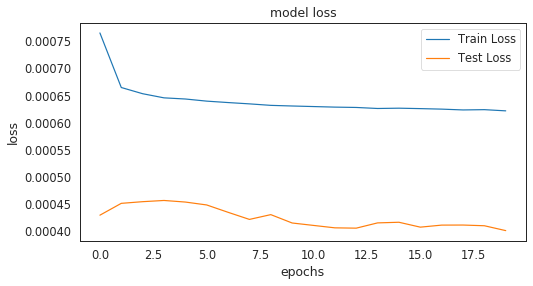

In [23]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

# Predictions


In [24]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.11358784880566515
Train Root Mean Squared Error: 0.2661337547236253
Test Mean Absolute Error: 0.0992429177238802
Test Root Mean Squared Error: 0.22125288493565795


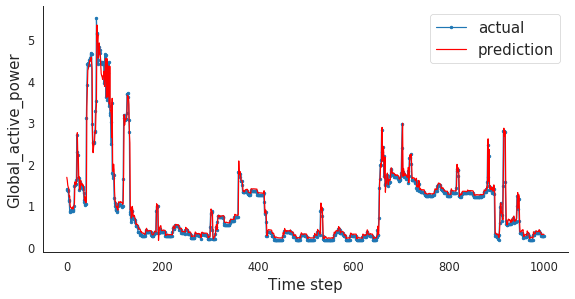

In [27]:
aa=[x for x in range(1000)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:1000], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:1000], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();